# Dataset & Linear Classifier

The [Adult Data Set][1] is a census income dataset from the UCI Machine Learning Repository. It can be used to predict whether an individual makes more than $50k per year. It is made up of census data from 1994 and has about 48 thousand examples and 14 features.
[1]: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.tree import DecisionTreeClassifier
from time import time
from sklearn.utils import shuffle
from sklearn.model_selection import permutation_test_score

## Understanding the Dataset

Let's first load the data

In [2]:
cols = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
        "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "class"]
url_train = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
train_df = pd.read_csv(url_train, names=cols, header=None)
test_df  = pd.read_csv(url_test, names=cols, skiprows=1)

In [3]:
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Now let's see how many missing values there are

In [4]:
train_df.isnull().sum(axis=0)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

Now let's look at the distribution of the features

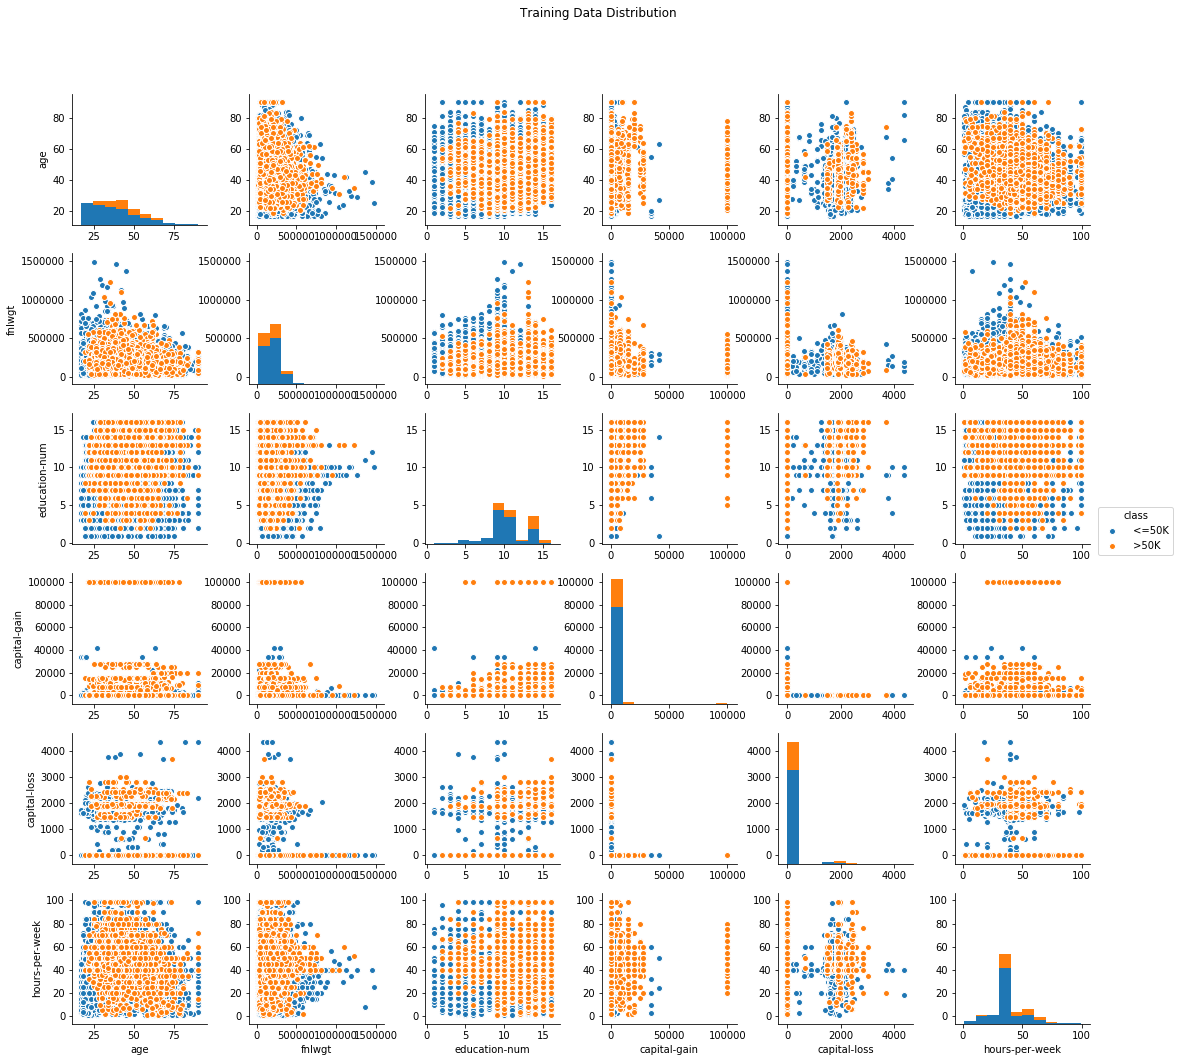

In [5]:
g = sns.pairplot(train_df, hue="class")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Training Data Distribution")
plt.show()

We will now view the correlations of the numerical features

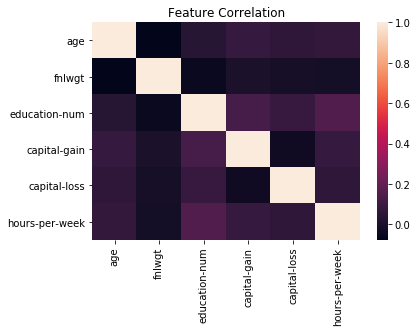

In [6]:
sns.heatmap(train_df.corr())
plt.title("Feature Correlation")
plt.show()

## Preprocessing

In [7]:
# One Hot Encoding
categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)
test_df["native-country_ Holand-Netherlands"] = 0 #
# convert class to 0 or 1
train_df["class"] = train_df["class"].astype('category')
train_df["class"] = train_df["class"].cat.codes
test_df["class"]  = test_df["class"].astype('category')
test_df["class"]  = test_df["class"].cat.codes

# Linear Classification
First, partition the data

In [8]:
X_train = train_df.drop("class", axis=1).as_matrix()
y_train = train_df["class"].as_matrix()
X_test = test_df.drop("class", axis=1).as_matrix()
y_test = test_df["class"].as_matrix()


We will now create the linear classifier, fit it, and then compute the scores using 10-fold cross-validation of each folds.

In [9]:
ridge_clf = linear_model.RidgeClassifier()
ridge_clf.fit(X_train, y_train) 
n_folds = 10
scores = cross_val_score(ridge_clf, X_train, y_train, cv=n_folds)
scores

array([ 0.83236107,  0.83937346,  0.84490172,  0.82985258,  0.84336609,
        0.83753071,  0.83753071,  0.84213759,  0.84121622,  0.84398034])

Finally, let's see the test set error

In [10]:
y_pred = cross_val_predict(ridge_clf, X_test, y_test, cv=n_folds)
accuracy_score(y_test, y_pred)

0.84202444567287027

# Gaussian Process Classification
Let's use 1,000 random examples to speed things up

In [11]:
stacked_train = np.column_stack([X_train, y_train])
subset_size_train = 1000
subset_train = stacked_train[np.random.choice(stacked_train.shape[0], subset_size_train, replace=False), :]

stacked_test = np.column_stack([X_test, y_test])
subset_size_test = 1000
subset_test = stacked_test[np.random.choice(stacked_test.shape[0], subset_size_test, replace=False), :]

Now that we've picked a subset of our data, let's split up the data into samples and labels again and fit a GP classifier.

In [12]:
y_train_subset = subset_train[:,-1]
X_train_subset = np.delete(subset_train, -1, axis = 1)

y_test_subset = subset_test[:,-1]
X_test_subset = np.delete(subset_test, -1, axis = 1)

Now, let's fit the GP classifier

In [13]:
GP_RBF = GaussianProcessClassifier(kernel = 1.0 * RBF(length_scale=1.0))
GP_matern = GaussianProcessClassifier(kernel = Matern(length_scale=2, nu=3/2))

t0 = time()
GP_RBF.fit(X_train_subset, y_train_subset)
t1 = time()
rbf_train_time = t1 - t0

In [14]:
t2 = time()
GP_matern.fit(X_train_subset, y_train_subset)
t3 = time()
matern_train_time = t3 - t2

In [15]:
t4 = time()
rbf_scores = cross_val_score(GP_RBF, X_train_subset, y_train_subset, cv=n_folds)
t5 = time()
rbf_test_time = t5 - t4
print("%0.2f +/- %0.2f" % (np.mean(rbf_scores), np.std(rbf_scores)))

0.75 +/- 0.02


In [16]:
t6 = time()
matern_scores = cross_val_score(GP_matern, X_train_subset, y_train_subset, cv=n_folds)
t7 = time()
matern_test_time = t7 - t6
print("%0.2f +/- %0.2f" % (np.mean(matern_scores), np.std(matern_scores)))

0.75 +/- 0.04


In [17]:
print("RBF training time: %.2fs \nMatern training time: %.2fs \nRBF 10-fold CV time: %.2fs \
\nMatern 10-fold CV time: %.2fs" % (rbf_train_time, matern_train_time, rbf_test_time, matern_test_time))

RBF training time: 1.13s 
Matern training time: 5.69s 
RBF 10-fold CV time: 7.14s 
Matern 10-fold CV time: 37.19s


In [18]:
t8 = time()
RBF_y_pred = cross_val_predict(GP_RBF, X_test_subset, y_test_subset, cv = n_folds)
t9 = time()
RBF_pred_time = t9 - t8
print("RBF accuracy: %0.2f%%" % accuracy_score(y_test_subset, RBF_y_pred))

RBF accuracy: 0.74%


In [19]:
t10 = time()
matern_y_pred = cross_val_predict(GP_matern, X_test_subset, y_test_subset, cv = n_folds)
t11 = time()
matern_pred_time = t11 - t10
print("Matern accuracy: %0.2f%%" % accuracy_score(y_test_subset, matern_y_pred))

Matern accuracy: 0.77%


In [20]:
print("RBF 10-fold test time: took %0.2fs \nMatern 10-fold test time: %0.2fs" % (RBF_pred_time, matern_pred_time))

RBF 10-fold test time: took 7.01s 
Matern 10-fold test time: 54.72s


Now we will compare their negative log likelihoods

In [21]:
print("Log Marginal Likelihood (GP_RBF): %.3f" % GP_RBF.log_marginal_likelihood(GP_RBF.kernel_.theta))
print("Log Marginal Likelihood (GP_Matern): %.3f" % GP_matern.log_marginal_likelihood(GP_matern.kernel_.theta))

Log Marginal Likelihood (GP_RBF): -693.147
Log Marginal Likelihood (GP_Matern): -535.393


# Decision Tree Classifier

In [22]:
X_train = train_df.drop("class", axis=1).as_matrix()
y_train = train_df["class"].as_matrix()
X_test = test_df.drop("class", axis=1).as_matrix()
y_test = test_df["class"].as_matrix()

In [23]:
dtc_clf = DecisionTreeClassifier(random_state=0)
t0 = time()
dtc_clf.fit(X_train, y_train) 
n_folds = 10
scores = cross_val_score(dtc_clf, X_train, y_train, cv=n_folds)
t1 = time()
y_pred = cross_val_predict(dtc_clf, X_test, y_test, cv=n_folds)
print ("Train time:", round(t1 - t0, 3), "s")
print ("Prediction time:", round(time() - t1, 3), "s")
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy: {:.2f}%".format(accuracy))

Train time: 4.681 s
Prediction time: 1.833 s
Accuracy: 0.81%


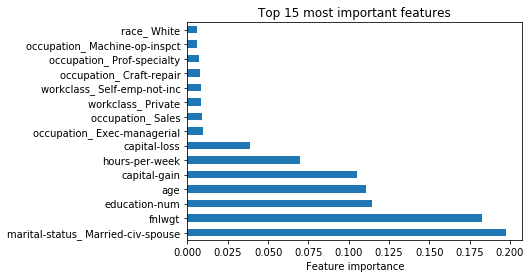

In [24]:
pd.Series(dtc_clf.feature_importances_, index=train_df.drop("class", axis=1).columns).nlargest(15).plot(kind='barh')
plt.title("Top 15 most important features")
plt.xlabel("Feature importance")
plt.show()

# Evaluation
For each model, we calculate the mean accuracy for 10-fold cross-validation with 10 runs
### Ridge regression Evaluation

In [25]:
num_runs = 10
ridge_cv_score_tot = 0.0
for i in range(num_runs):
    X, y = shuffle(X_train, y_train, random_state=i)
    ridge_cv_score_tot += cross_val_score(ridge_clf, X, y, cv=n_folds).mean()
print(ridge_cv_score_tot / num_runs)

0.839538182361


### Gaussian Processes Evaluation

In [26]:
rbf_cv_score_tot = 0.0
for i in range(10):
    X, y = shuffle(X_train_subset, y_train_subset, random_state=i)
    rbf_cv_score_tot += cross_val_score(GP_RBF, X, y, cv=n_folds).mean()
print (round((rbf_cv_score_tot / num_runs), 3))

0.757


In [29]:
matern_cv_score_tot = 0.0
for i in range(10):
    X, y = shuffle(X_train_subset, y_train_subset, random_state=i)
    matern_cv_score_tot += cross_val_score(GP_matern, X, y, cv=n_folds).mean()
print (round((matern_cv_score_tot / num_runs), 3))

0.746


### Decision Tree Evaluation

In [30]:
decision_tree_cv_score_tot = 0.0
for i in range(num_runs):
    X, y = shuffle(X_train, y_train, random_state=i)
    decision_tree_cv_score_tot += cross_val_score(dtc_clf, X, y, cv=n_folds).mean()
print(decision_tree_cv_score_tot / num_runs)

0.816231233955


### Statistical Significance 
The p-value is given by the percentage of runs for which the score obtained is greater than the classification score obtained in the first place.

In [31]:
score, permutation_scores, pvalue = permutation_test_score(ridge_clf, X_test, y_test, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("Ridge Classification score %s (pvalue : %s)" % (score, pvalue))

Ridge Classification score 0.842026309672 (pvalue : 0.00990099009901)


In [33]:
score, permutation_scores, pvalue = permutation_test_score(GP_RBF, X_test_subset, y_test_subset, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("GP (RBF) Classification score %s (pvalue : %s)" % (score, pvalue))

score, permutation_scores, pvalue = permutation_test_score(GP_matern, X_test_subset, y_test_subset, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("GP (Matern) Classification score %s (pvalue : %s)" % (score, pvalue))

GP (RBF) Classification score 0.74196929693 (pvalue : 0.861386138614)
GP (Matern) Classification score 0.774052105211 (pvalue : 0.00990099009901)


In [34]:
score, permutation_scores, pvalue = permutation_test_score(dtc_clf, X_test, y_test, scoring="accuracy", cv=n_folds, n_permutations=100, n_jobs=1)
print("Decision Tree Classification score %s (pvalue : %s)" % (score, pvalue))

Decision Tree Classification score 0.814568694027 (pvalue : 0.00990099009901)
